In [1]:
# TODO: Delete cell
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/DSA5203 Project/hw_3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
Guideline of your submission of HW3.
If you have any questions in regard to submission,
please contact TA: Zheng Huan <huan_zheng@u.nus.edu>
"""
import os
import glob
import pandas as pd
from PIL import Image
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
import random
import numpy as np

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

# Import Custom Classes for ImageDataset, ImageClassificationBase, ResnetCnnModel and DeviceDataLoade
# from custom_classes import ImageDataset, ImageClassificationBase, ResnetCnnModel, DeviceDataLoader

# Add these lines at the beginning of your script
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

# Import the ImageDataset class from the separate file
from image_dataset import ImageDataset

In [3]:
# define our random seed etc.
SEED = 42
TRAIN_TEST_SPLIT_RATIO = 0.8
LABEL_MAPPING = {"bedroom":1,
                  "Coast":2,
                  "Forest":3,
                  "Highway":4,
                  "industrial":5,
                  "Insidecity":6,
                  "kitchen":7,
                  "livingroom":8,
                  "Mountain":9,
                  "Office":10,
                  "OpenCountry":11,
                  "store":12,
                  "Street":13,
                  "Suburb":14,
                  "TallBuilding":15}

# Set Hyperparameter
batch_size = 32
shuffle = True
num_classes = 15
pin_memory = True
num_workers = 4 # use 4 workers for parallelization
opt_func = torch.optim.Adam
num_epochs = 100
learning_rate = 0.001

# set seed for code reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

# Set the seed for reproducibility throughout to get same results.
set_seed(SEED)
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
torch.set_num_threads(1)

In [4]:
def create_dataset(data_dir, load_type="train"):
    """
    Load dataset from the data directory & return dataloader object of loaded data

    data_dir: str() of data directory
    load_type: str() type of loading to perform. train or test.
    :return: dataloader object of data
    """
    # 1. Load Dataset
    # load the labels dataset
    image_list = []
    labels_list = []
    encode_list = []
    for label in os.listdir(data_dir):
        # convert to lowercase
        # label = label.lower()
        folder_label_path = os.path.join(data_dir, label)
        folder_img_list = glob.glob(f"{folder_label_path}/*.jpg")
        image_list += folder_img_list
        labels_list += [label]*len(folder_img_list)
        encode_list += [LABEL_MAPPING[label]-1]*len(folder_img_list) # subtract 1 from encode_list to ensure that the num_classes works properly.

    df = pd.DataFrame({
        "file_path":image_list,
        "encoded_labels":encode_list,
        "label":labels_list,
        })

    # Class distribution
    class_dist = df.groupby("label").agg({"file_path":"count"}).reset_index()

    # Number of samples per class
    num_samples = class_dist["file_path"].min()

    # 2. Data pipeline
    # Transform our dataset, based on the mean and standard deviations of the RGB channel of the pretrained model we want to use
    trans = transforms.Compose([
        # resizing the image to be a fixed size
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    if load_type=="train":
      # Train test split at 0.8:0.2
      train_df = df.groupby("label").sample(n=int(num_samples*TRAIN_TEST_SPLIT_RATIO), 
                                          random_state=SEED)
      valid_df = df[~df.index.isin(train_df.index)]

      # setting data loaders
      train_set = ImageDataset(train_df, transform=trans)
      valid_set = ImageDataset(valid_df, transform=trans)
      train_dl = DataLoader(train_set, 
                          batch_size, 
                          shuffle=shuffle, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)
      # batch_size can be multiplied by 2 since there is no backprop done for test & validation set
      valid_dl = DataLoader(valid_set, 
                          batch_size*2, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)
      return (train_dl, valid_dl)
    else:
      test_df = df
      # setting our data loaders
      test_set = ImageDataset(test_df, transform=trans)
      test_dl = DataLoader(test_set, 
                           batch_size*2, 
                           shuffle=shuffle, 
                           num_workers=num_workers, 
                           pin_memory=pin_memory)
      return test_dl

# Define Class that contains training steps required and for calculation of training / validation accuracy

In [5]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Accuracy function

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define our ResnetCNNModel Class pretrained model
- we define a network head so that we are able to fit it to our specific dataset

In [7]:
class ResnetCnnModel(ImageClassificationBase, nn.Module):
    def __init__(self):
        super(ResnetCnnModel, self).__init__()
        model = models.resnet50(weights="IMAGENET1K_V2")
        numFeatures = model.fc.in_features
        # using the ResNet50 model as a feature extractor we set
        # its parameters to non-trainable (by default they are trainable)
        for param in model.parameters():
            param.requires_grad = False
        # define the network head and attach it to the model
        headModel = nn.Sequential(
            nn.Linear(numFeatures, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        model.fc = headModel

        self.model = model

    def forward(self, images):
        return self.model(images)

# Device Loader

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Define evauate and fit functions
- For our fit functions, we define a learning rate scheduler to decay by a factor of 0.1 if val_loss stops decreasing for 5 consecutive 5 epochs, this is so as to facilitate better training.
- Early Stopping Criteria was defined for a patience of 5, so that we prevent the model from overfitting to training data and save the best weights before it happens for best validation accuracy results.

In [9]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    best_val = 0
    optimizer = opt_func(model.parameters(), lr)
    # learning rate will be decreased by a factor of 0.1 if the validation loss does not improve for 1 consecutive epochs.
    # decrease the learning rate when the validation loss stops decreasing for 1 consecutive epochs.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)
    
    # implementation of early stopping
    early_stop_count = 0
    early_stop_patience = 3 # if val loss does not improve after 3 epochs, stop the training and save the model.
    

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Early Stopping by saving the model with the best weight
        if result["val_acc"] > best_val:
            
            # check if model_dir path exists, if not, create it on the fly.
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            
            # save the model
            torch.save(model.state_dict(), RESNET_WEIGHTS_PATH)
            print(f"Model saved at: {RESNET_WEIGHTS_PATH}")
            best_val = result["val_acc"]
        else:
            early_stop_count += 1
            if early_stop_count == early_stop_patience:
                print(f"Early Stopping implemented at epoch: {epoch}")
                break


        # Update the learning rate using the scheduler
        scheduler.step(result["val_loss"])
    

    return history

# Define our Training function 'train'

In [10]:
def train(train_data_dir, model_dir, **kwargs):
    """Main training model.

    Arguments:
        train_data_dir (str):   The directory of training data
        model_dir (str):        The directory of the saved model.
        **kwargs (optional):    Other kwargs. Please specify default values if needed.

    Return:
        train_accuracy (float): The training accuracy.
    """
    RESNET_WEIGHTS_PATH = model_dir

    # load the dataset
    train_dl, valid_dl = create_dataset(train_data_dir, load_type="train")

    # storing history
    history = []
    
    # init the model
    resnet_model = ResnetCnnModel()

    # move model and dataset to GPU/CPU
    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)
    resnet_model = to_device(resnet_model, device)

    # train the model
    history = fit(num_epochs, learning_rate, resnet_model, train_dl, valid_dl, opt_func)
        
    # evaluate on validation dataset.
    # load trained model from model_dir and calculate the evaluated validation accuracy and return as output
    if os.path.exists(RESNET_WEIGHTS_PATH):
        # use GPU
        if torch.cuda.is_available():
            resnet_model.load_state_dict(torch.load(RESNET_WEIGHTS_PATH))
        else:
            resnet_model.load_state_dict(torch.load(RESNET_WEIGHTS_PATH, map_location=torch.device('cpu')))
        result = evaluate(resnet_model, valid_dl)
        print(f'Validation Accuracy: {result["val_acc"]}')
        
    return history

# Define our test functions

### Recall that our test directory is under test_data_dir

In [11]:
def test(test_data_dir, model_dir, **kwargs):
    """Main testing model.

    Arguments:
        test_data_dir (str):    The `test_data_dir` is blind to you. But this directory will have the same folder structure as the `train_data_dir`.
                                You could reuse the snippets of loading data in `train` function
        model_dir (str):        The directory of the saved model. You should load your pretrained model for testing
        **kwargs (optional):    Other kwargs. Please specify default values if needed.

    Return:
        test_accuracy (float): The testing accuracy.
    """
    RESNET_WEIGHTS_PATH = model_dir

    # load the dataset
    test_dl = create_dataset(test_data_dir, load_type="test")

    # Load pretrained CNN model from model directory titled 'trained_cnn.pth' from RESNET_WEIGHTS_PATH
    if os.path.exists(RESNET_WEIGHTS_PATH):
        resnet_model = ResnetCnnModel()

        # use GPU
        if torch.cuda.is_available():
            resnet_model.load_state_dict(torch.load(RESNET_WEIGHTS_PATH))
        else:
            resnet_model.load_state_dict(torch.load(RESNET_WEIGHTS_PATH, map_location=torch.device('cpu')))
        
        # move model and dataset to GPU/CPU
        device = get_default_device()
        test_dl = DeviceDataLoader(test_dl, device)
        resnet_model = to_device(resnet_model, device)

        # Evaluate the test data using our pretrained model (blind to us)
        result = evaluate(resnet_model, test_dl)
        print(f'Test Accuracy: {result["val_acc"]}')
        return result["val_acc"]
    else:
        print("Model weights not found.")
        return None


# Run

In [12]:
CURRENT_PATH = "/content/drive/MyDrive/DSA5203 Project/hw_3"
train_data_dir = os.path.join(CURRENT_PATH,"train")
test_data_dir = os.path.join(CURRENT_PATH,"train") # for training data folder specified in question
model_dir = os.path.join(CURRENT_PATH,"model")
RESNET_WEIGHTS_PATH = os.path.join(model_dir, "trained_cnn.pth") # label the file name according to how the prof wants it

In [13]:
training_history = train(train_data_dir, RESNET_WEIGHTS_PATH)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 1.9821, val_loss: 1.0908, val_acc: 0.7659
Model saved at: /content/drive/MyDrive/DSA5203 Project/hw_3/model/trained_cnn.pth
Epoch [1], train_loss: 0.8665, val_loss: 0.5590, val_acc: 0.7994
Model saved at: /content/drive/MyDrive/DSA5203 Project/hw_3/model/trained_cnn.pth
Epoch [2], train_loss: 0.4910, val_loss: 0.3351, val_acc: 0.8878
Model saved at: /content/drive/MyDrive/DSA5203 Project/hw_3/model/trained_cnn.pth
Epoch [3], train_loss: 0.3511, val_loss: 0.2971, val_acc: 0.9003
Model saved at: /content/drive/MyDrive/DSA5203 Project/hw_3/model/trained_cnn.pth
Epoch [4], train_loss: 0.2458, val_loss: 0.3065, val_acc: 0.8815
Epoch [5], train_loss: 0.2312, val_loss: 0.2583, val_acc: 0.9173
Model saved at: /content/drive/MyDrive/DSA5203 Project/hw_3/model/trained_cnn.pth
Epoch [6], train_loss: 0.1519, val_loss: 0.2474, val_acc: 0.9236
Model saved at: /content/drive/MyDrive/DSA5203 Project/hw_3/model/trained_cnn.pth
Epoch [7], train_loss: 0.1413, val_loss: 0.2590, val_

In [14]:
test(test_data_dir, RESNET_WEIGHTS_PATH)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 0.9830729365348816


0.9830729365348816

In [15]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    


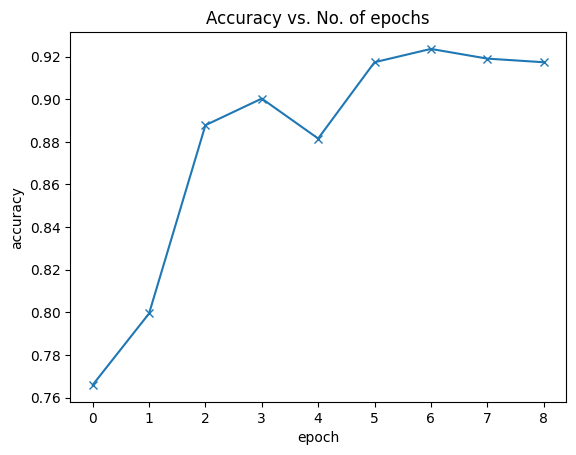

In [16]:
plot_accuracies(training_history)

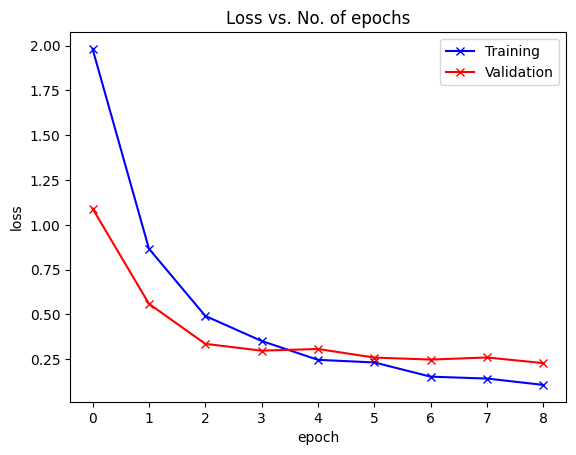

In [17]:
plot_losses(training_history)